In [3]:
%matplotlib inline
from Stupid_digits import *
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from matplotlib import animation
from copy import copy

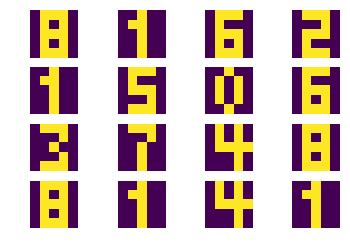

In [4]:
# X are mormalizied digits to have overall activity 10
X,y = stupid_digits_dataset(100)
plt.figure('data')
for i in np.arange(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X[i].reshape((5,5)), interpolation=None)
    plt.axis('off')
plt.show()

In [5]:
from brian2 import *
import numpy as np
from time import clock

import json
import codecs

def sv_json(obj, p,encoding="cp1251"):
    with codecs.open(p, "w",encoding=encoding) as f:
        json.dump(obj,f,indent=1,ensure_ascii=0)
        
def ld_json(p,encoding="cp1251"):
    with codecs.open(p,"r",encoding=encoding) as f:
        return json.load(f)

start_scope()

time_per_image = 100*ms
time_step = 0.1*ms
tau = 10*ms # tau for neuron's voltage 'v'
tau_I = 15*ms # tau for neuron's current 'I'
tau_h = 50*ms # tau for neuron's treshold

wmax = 1.
decay = 0.001

eqs_input_neuron = '''
rates : Hz
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
train :1
'''

eqs_output_neuron = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
dI_intr/dt = -I_intr/tau_I :1
I_teacher :1
I = I_inp + I_intr + I_teacher : 1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
dhold_output/dt = -hold_output/tau_h  : 1
fixed_hold_output = clip(hold_output, 1, 5) :1
train :1
'''
#fixed_hold_output = clip(hold_output, 1, 100) :1

eqs_input_syn = '''
w : 1
'''

# equations that describe changes if presynaptic spike of the forward-riented synapse of input layer occures
eqs_input_pre = '''
I_inp_post += w * c_inp
a_pre += 1./classes *1*ms/(alpha)
theta_pre += 1./classes *1*ms/(beta)
'''

# equations that describe changes if postsynaptic spike of the forward synapse occures
eqs_input_post = '''
a_post += 1./n_input *1*ms/(alpha)
theta_post += 1./n_input *1*ms/(beta)
w = clip(w + train_post*(-decay + lr*diff_pre), 0, wmax)
'''

eqs_intrinsic_output_syn = '''
w: 1
'''

# equations that describe changes if spike of the intr output synapse occures
eqs_intrinsic_output_pre = '''
I_intr_post += w * c_intr_out
'''

eqs_intrinsic_output_post = '''
w = clip(w + train_pre*(-lr_intr*diff_pre), -wmax, 0)
'''


reset_output = '''
v = 0
hold_output += 0.1*classes
'''

class Perceptron(object):
    def __init__(self, X, y, params_to_optimize, inits = None, monitor = None, cheat = False, mod = True, 
                high_verbosity=True):
        
        '''
        X - np.array with shape (N samples, N features)
        y - np.array with shape (N samples)
        n_hiiden - number of hidden neurons
        inits  - list of 2 lists that contain 'distribution' and 'condition' parameters 
        for input, intrinsic, output and intrinsic_output connections
            Example: inits = [['equal_[0,1]', None], ['equal_[-1,0]', 'i!=j']]
        monitor - dictionary with keys 'P', 'G', 'H' or connection names. Each key argument value is dictionary.
        Contains a list of what parameters to record for the object in the key name and dt.
            Example: monitor = {'H':{'variables':[['a','I'],'dt':25*ms, 'record':True]}}
        cheat - True if you wanna use pretrained model with first layer initialized from some objects of training data
        '''
        
        self.high_verbosity = high_verbosity
        global alpha, beta, lr, lr_intr, c_inp, c_intr_out, c_diff, Teacher_amplitude

        alpha = params_to_optimize['alpha']
        beta = params_to_optimize['beta']
        lr = params_to_optimize['lr']
        lr_intr = params_to_optimize['lr_intr']
        c_inp = params_to_optimize['c_inp']
        c_intr_out = params_to_optimize['c_intr_out']
        c_diff = params_to_optimize['c_diff']
        Teacher_amplitude = params_to_optimize['Teacher_amplitude']
        
        self.X = X
        if self.X is not None:
            n_input = int(X.shape[1])
        else:
            raise ValueError('No data provided to the simulation')
        
        self.y = y
        classes = int(len(set(y)))
        
        # list to store initial values for synapses in order [input, intrinsic, output, intrinsic_output]
        if inits:
            pass
        else:
            inits = [['equal_[0,1]', None], ['equal_[-1,0]', 'i!=j']]
         
        #creatitng the network: groups and synapses
        
        self.P = NeuronGroup(n_input, eqs_input_neuron, threshold='rand()<rates*dt', method='linear', 
                             refractory=2*ms, dt = time_step, name='P')
        #experiment
        self.M = NeuronGroup(n_input, eqs_input_neuron, threshold='rand()<rates*dt', method='linear',
                             refractory=2*ms, dt = time_step, name='M')
        self.H = NeuronGroup(classes, eqs_output_neuron, method=linear, threshold='v > fixed_hold_output', 
                             reset=reset_output, refractory=2*ms, dt=time_step, name = 'H')
        self.create_synapse('input_syn', self.P, self.H, eqs_input_syn, eqs_input_pre, eqs_input_post,
                           distribution=inits[0][0], condition=inits[0][1])
        self.create_synapse('input_inverse_syn', self.M, self.H, eqs_input_syn, eqs_input_pre, eqs_input_post,
                           distribution=inits[0][0], condition=inits[0][1])
        self.create_synapse('intrinsic_output_syn', self.H, self.H, eqs_intrinsic_output_syn, 
                            eqs_intrinsic_output_pre, eqs_intrinsic_output_post, 
                            distribution=inits[1][0], condition=inits[1][1])
        
        # set random values to a and theta for all groups, set train parameter of the group to 1.
        self.random_init_groups([self.P, self.M, self.H], [1, 1, 1])
        
        # operation to do during simulation every dt 
        self.network_op = NetworkOperation(self.update_func, dt=time_per_image)
        
        # params to give for constructing the simulation
        params = [self.P, self.M, self.H, self.input_syn, self.input_inverse_syn, 
                  self.intrinsic_output_syn, self.network_op]
        
        self.monitor = monitor
        # adding monitors to the simulation params
        # TO DO: OPTIMIZE!!!!!
        if self.monitor:
            if 'P' in self.monitor.keys():
                self.StateMonitorP = StateMonitor(self.P, self.monitor['P']['variables'], record=self.monitor['P']['record'],
                                                  dt=monitor['P']['dt'],
                                                  name = 'StateMonitorP')
                params.append(self.StateMonitorP)
            else:
                self.StateMonitorP = None
                
            if 'M' in monitor.keys():
                self.StateMonitorM = StateMonitor(self.M, self.monitor['M']['variables'], record=self.monitor['M']['record'], 
                                                  dt=monitor['M']['dt'],
                                                  name = 'StateMonitorM')
                params.append(self.StateMonitorM)
            else:
                self.StateMonitorM = None
                
            if 'H' in monitor.keys():
                self.StateMonitorH = StateMonitor(self.H, self.monitor['H']['variables'], record=self.monitor['H']['record'], 
                                                  dt=monitor['H']['dt'],
                                                  name = 'StateMonitorH')
                params.append(self.StateMonitorH)
            else:
                self.StateMonitorH = None
                
            if 'Input_weights' in monitor.keys():
                self.SynapseMonitorInput = StateMonitor(self.input_syn, self.monitor['Input_weights']['variables'], 
                                                        record=self.monitor['Input_weights']['record'],
                                                        dt = monitor['Input_weights']['dt'],
                                                        name = 'SynapseMonitorInput')
                params.append(self.SynapseMonitorInput)
            else:
                self.SynapseMonitorInput = None
                
            if 'Input_inverse_weights' in monitor.keys():
                self.SynapseMonitorInputInverse = StateMonitor(self.input_inverse_syn, self.monitor['Input_inverse_weights']['variables'], 
                                                        record=self.monitor['Input_inverse_weights']['record'],
                                                        dt = monitor['Input_inverse_weights']['dt'],
                                                        name = 'SynapseMonitorInputInverse')
                params.append(self.SynapseMonitorInputInverse)
            else:
                self.SynapseMonitorInputInverse = None
            
            if 'Intrinsic_output_weights' in monitor.keys():
                self.SynapseMonitorIntrinsicOutput = StateMonitor(self.intrinsic_output_syn, self.monitor['Intrinsic_output_weights']['variables'],
                                                        record=self.monitor['Intrinsic_output_weights']['record'], 
                                                        dt = monitor['Intrinsic_output_weights']['dt'],
                                                        name = 'SynapseMonitorIntrinsicOutput')
                params.append(self.SynapseMonitorIntrinsicOutput)
            else:
                self.SynapseMonitorIntrinsicOutput = None
        
        # setting params to the simulation
        self.network = Network(params)
        if self.high_verbosity:
            print ('Network created using:')
            for param in params:
                print ('\t'+param.name + '   dt = '+str(param.clock.dt))
            
        self.shown_labels = [] #list to store shown labels during lifetime of the simulation
        self.predictions = [] #list to store preds during lifetime of the simulation
        self.counter = 0 # counter for shown images during lifetime of the simulation
        self.mod = mod # binary, True if train mod, False for test mod
        self.clocks = [] # clocks list per image to monitor if there are to many params to record and RAM is dying 
        self.clocks.append(0)
        
        # never use this
        if cheat:
            dig_y = y[:int(n_hidden)]
            dig_X = X[:int(n_hidden)]
            for s in np.arange(int(n_hidden)):
                for j in np.arange(int(n_input)):
                    # shape dig_X = (n_hidden, n_input)
                    # shape inp_syn is a vectorized matrix
                    # W_11 ..... W_n1
                    # ..
                    # W_1m ..... W_nm
                    # where n is post length, m is pre length
                    self.input_syn.w[s+j*int(n_hidden)] = dig_X[s][j]
            print ('ALARRRM !!! CHEATER !!! I used cheat initialisation')
    
    def random_init_groups(self, groups, trains):
        '''
        random inits for a and theta of neuron groups + setting trains for neuron groups
        groups - list of NeuronGroup objects, trains - list of train values (Ex. [1, 1, 1] if all are trainable)'''
        if self.high_verbosity:
            print ()
        for group,tr in zip(groups, trains):
            if tr:
                group.train = np.ones_like(group.train)
                if self.high_verbosity:
                    print (group.name + ' ' + str(group.N) + ' trainable')
            else:
                group.train = np.zeros_like(group.train)
                if self.high_verbosity:
                    print (group.name + ' non-trainable')
            group.a = np.random.rand(len(group))*0.5
            group.theta = np.random.rand(len(group))*0.5
        if self.high_verbosity:
            print ()
    
    def create_synapse(self, name, pre, post, eqs, on_pre, on_post, distribution = 'equal_[0,1]', condition = None):
        
        '''
        AUTO-creating synapses between pre and post NeuronGroup with name='name'
        eqs, on_pre, on_post -  standart parameteres for Synapses
        distribution - string, initial values for weights
        condition - string, some cpecific conditions for connecting, same as in connect() method for Synapses
        extra value for conditions is 'reciprocal'. Should be used if Synapse object has w_rec reciprocal weights'''
        
        exec('self.'+ name + '= Synapses(pre, post, eqs, on_pre = on_pre, on_post = on_post, dt = time_step)')
        if self.high_verbosity:
            print ('{} -> {}, initial distribution = {}'.format(pre.name, post.name, distribution))
        if condition:
            if condition == 'reciprocal':
                exec('self.'+ name + '.connect()')
            else:
                exec('self.'+ name + ".connect(condition = '" + condition +"')")
        else: 
            exec('self.'+ name + '.connect()')
        
        if distribution:
            flag = 0
        if distribution == 'equal_[0,1]':    
            exec('self.' + name +'.w = np.random.random(len(pre)*len(post))')
            flag = 1
        if distribution == 'equal_[-1,1]'and condition == 'i!=j':
            exec('self.' + name +'.w = (np.random.random(len(pre)*(len(post)-1)) - 0.5) * 2.')
            flag = 1
        if distribution == 'equal_[-1,0]'and condition == 'i!=j':
            exec('self.' + name +'.w = (np.random.random(len(pre)*(len(post)-1)) - 1.)')  
            flag = 1
        if distribution == 'norm':
            exec('self.' + name +'.w = np.random.randn(len(pre)*len(post))')
            flag = 1
        if distribution == 'zeros':
            exec('self.' + name +'.w = np.zeros_like(self.' + name +'.w)')     
            flag = 1
        if distribution == 'ones':
            exec('self.' + name +'.w = np.ones_like(self.' + name +'.w)')
            flag = 1
            
        if condition == 'reciprocal':
            exec('self.' + name +'.w_rec = np.array(self.' + name +'.w).transpose()')
            flag = 1
        
        if self.high_verbosity and flag==0:
            print ('SOMETHING WENT WRONG, check your distribution and condition paramaeters: {}, {}'.format(distribution, condition))
        
        
    def sample_data(self):
        '''
        Sampling random X vector from X and correspondinf label from y
        '''
        sample = np.random.randint(0, self.X.shape[0])
        self.clocks.append(clock())
        return self.X[sample], self.y[sample]

    def update_func(self):
            
        # active phase
        if self.counter % 2 == 0:
        
            image_sample, label_sample = self.sample_data()
            if self.high_verbosity:
                print ('Processing {} image with label {}'.format(self.counter/2, label_sample))

            self.P.rates = [k*250*Hz for k in image_sample]
            self.M.rates = [(1-k)*250*Hz for k in image_sample]
            if self.mod:
                self.H.I_teacher = np.zeros_like(self.H.I_teacher)
                self.H.I_teacher[int(label_sample)] = Teacher_amplitude
                #self.H.train = np.zeros_like(self.H.train)
                #self.H.train[int(label_sample)] = 1.
            else: 
                self.H.I_teacher = np.zeros_like(self.H.I_teacher)
                self.H.train = np.zeros_like(self.H.train)
            # saving shown labels
            self.shown_labels.append(int(label_sample))
        
        # resting phase
        else:
            self.P.rates = np.zeros_like(self.P.rates)
            self.M.rates = np.zeros_like(self.M.rates)
            self.H.I_inp = np.zeros_like(self.H.I_inp)
            self.H.I_intr = np.zeros_like(self.H.I_intr)
            if self.mod:
                self.H.I_teacher = np.zeros_like(self.H.I_teacher)
                #self.H.train = np.zeros_like(self.H.train)
                
            # saving predictions
            pred = np.argmax(np.mean(self.StateMonitorH.a[:,-int(time_per_image/(2.*ms)):], axis=1))
            self.predictions.append(pred)
            if self.high_verbosity:
                #print(self.StateMonitorH['a'][:,-1])
                print(np.max(self.StateMonitorH.a[:,-1]))
                print(np.max(self.StateMonitorH.I_inp[:,-1]))
                print(np.min(self.StateMonitorH.I_intr[:,-1]))
                if self.predictions[-1] == self.shown_labels[-1]:
                    print ('correct', pred)
                else:
                    print ('incorrect', pred)
        self.counter += 1

    def run(self, runtime):
        self.network.run(runtime)
        
    def save_weights(self, path, encoding="cp1251"):
        print ("сохранение сети в файл", path)
        weights = {}
        weights['Input_weights'] = list(self.input_syn.w)
        weights['Intrinsic_output_weights'] = list(self.intrinsic_output_syn.w)
        weights['Input_inverse_weights'] = list(self.input_inverse_syn.w)
        
        sv_json(weights, path, encoding=encoding)
    
    def load_weights(self, path, encoding="cp1251"):
        print ("загрузка сети из файла", path)
        weights = ld_json(path, encoding=encoding)
        self.input_syn.w = weights['Input_weights']
        self.intrinsic_output_syn.w = weights['Intrinsic_output_weights']
        self.input_inverse_syn.w = weights['Input_inverse_weights']
        
    def plot_clocks(self):
        '''
        Plot values of np.diff(self.clocks) to look of there are some errors during "run". If there 
        are huge picks in the middle of simulation on this graph, than it is likely that there are to 
        much recording variables or neurons in Monitors.
        '''
        figure('plot_clocks')
        plot(np.arange(1, len(self.clocks)), np.diff(self.clocks))
        if self.high_verbosity:
            print('INIT', np.sum(np.diff(self.clocks))[:2])
            print('MEAN', np.mean(np.diff(self.clocks)[2:]), 'STD', np.std(np.diff(self.clocks))[2:])
        show()
    
    def plot_H(self, variables, interval, neuron_indexes):
        '''
        Plotting all recording variables for H group on 'interval' period for 'neuron_indexes' neurons.
        Note that neuron_indexes is a sub-list from monitor['H'][2] list (remember if it was 'True', than all neurons 
        of this NeuronGroup were recorded)
        '''
        figure('H', figsize=(10, len(variables)*5))
        for _, m in enumerate(variables):
            subplot(len(variables), 1, _+1)
            title(m)
            for j in neuron_indexes:
                exec('plot(interval, self.StateMonitorH.'+str(m)+'[j][interval[0]:interval[-1]+1], label = str(j))')
            legend(loc='best')
        show()
        
    def plot_weights(self, weights_type, interval, weights_indexes):
        '''
        Plotting weights evolution for 'weights_type' on 'interval' period of time for 'weights_indexes' weights.
        Note that weights_indexes is a sub-list from monitor[$weights_type][2] list (remember if it was 'True', than all weights 
        of this type in this Synapse are recorded)
        '''
        
        if weights_type == 'Input_weights':
            if self.SynapseMonitorInput:
                values = self.SynapseMonitorInput.w
            else:
                raise NameError('There was no record of this synapse')
            
        elif weights_type == 'Input_inverse_weights':
            if self.SynapseMonitorInputInverse:
                values = self.SynapseMonitorInputInverse.w
            else:
                raise NameError('There was no record of this synapse')
        
        elif weights_type == 'Intrinsic_output_weights':
            if self.SynapseMonitorIntrinsicOutput:
                values = self.SynapseMonitorIntrinsicOutput.w
            else:
                raise NameError('There was no record of this synapse')
        else:
            raise NameError('Incorrect weights_type')
        
        
        figure(weights_type, figsize=(10, 5))
        title(weights_type)
        for j in weights_indexes:
            plot(interval, values[j], label = str(j))
        #legend(loc='best')
        show()
        
    def imshow_forward_weights(self, gr, N, M, n, m):
        '''
        Plotting forward weights of 'gr' NeuronGroup on one figure.
        gr - 'H'
        N, M - height and width of figure in subplots
        n, m - height and width of weight image
        '''

        if gr == 'H':
            group1 = self.P
            group2 = self.H
            group3 = self.M
            name1 = 'imshow_input_weights'
            name2 = 'imshow_input_inverse_weights'
            np_images1 = np.array(self.input_syn.w)
            np_images2 = np.array(self.input_inverse_syn.w)
        else:
            raise NameError('No such group')

        images_shape1=[len(group1), len(group2)]
        self.one_image(np_mts=np_images1, mts_shape=images_shape1, N=N, M=M, n=n, m=m, frame=None,
                       name=name1)
        
        images_shape2=[len(group3), len(group2)]
        self.one_image(np_mts=np_images2, mts_shape=images_shape2, N=N, M=M, n=n, m=m, frame=None,
                       name=name2)
        
    
    def imshow_intrinsic_weights(self, gr, N, M, n, m):
        '''
        Plotting intrinsic weights of 'gr' NeuronGroup on one figure.
        gr - 'H'
        N, M - height and width of figure in subplots
        n, m - height and width of weight image
        '''
        
        if gr == 'H':
            group = self.H
            z = self.intrinsic_output_syn.w
        else:
            raise NameError('No such group')
        
        for i in np.arange(int(len(group))):
            z = insert(z, i+int(len(group))*i, 0)
    
        np_mts = np.array(z)
        mts_shape=[len(group), len(group)]
        
        self.one_image(np_mts=np_mts, mts_shape=mts_shape, N=N, M=M, n=n, m=m, intrinsic=True, 
                       name='imshow_intrinsic_weights')
        
    def one_image(self, np_mts, mts_shape, N, M, n, m, frame=None, intrinsic=False, name=None, video=False):
        '''
        Plotting image of np_mts frame
        np_mts - numpy array of multivariate timeseries (or just numpy array for fixed frame)
        mts_shape - list [amount of neurons in pre group, amount of neurons in post group]
        frame - frame of timeseries, None if np_mts is just numpy array of weights instead of synapse monitor mts
        N, M - height and width of figure in "subplots"
        n, m - height and width of weight image
        intrinsic - True if visualising intrinsic weights
        name - unique name of the figure
        '''
        if intrinsic:
            images = np.array(np_mts).reshape(int(mts_shape[1]), int(n), int(m))
        else:
            images = [[np_mts[r + j * int(mts_shape[1])][frame]
                        for j in np.arange(mts_shape[0])] 
                        for r in np.arange(mts_shape[1])]
            images = np.array(images).reshape(int(mts_shape[1]), int(n), int(m))

        horizontal_lines = np.ones((1, M*(m+1)+1))*(np.nan)

        for i in np.arange(N):
            horizontal_line = np.ones((images[0].shape[0],1))*(np.nan)
            for j in np.arange(M):
                im = np.hstack((images[int(j+i*M)],np.ones((images[int(j+i*M)].shape[0],1))*(np.nan)))
                horizontal_line = np.hstack((horizontal_line, im))
            horizontal_line = np.vstack((horizontal_line, np.ones((1, M*(m+1)+1))*(np.nan)))
            horizontal_lines = np.vstack((horizontal_lines, horizontal_line))
        
        if video:
            return horizontal_lines
        else:
            figure(name, figsize=(4, 4*N/M))
            title(name)
            imshow(horizontal_lines, interpolation=None, cmap='winter')
            colorbar()
            axis('off')
            show()

    def animate_input_weights(self, name, N, M, n, m, start=0, end=None):
        group1 = self.P
        group2 = self.H
        np_images = np.array(self.SynapseMonitorInput.w)
        images_shape=[len(group1), len(group2)]
        if end:
            pass
        else:
            end = self.SynapseMonitorInput.w.shape[1]-1
        
        print (end)
        NN.animate_weights(name, np_mts=np_images, mts_shape=images_shape, start=start, end=end,
                           N=N, M=M, n=n, m=m, intrinsic=False)
        
    def animate_input_inverse_weights(self, name, N, M, n, m, start=0, end=None):
        group1 = self.M
        group2 = self.H
        np_images = np.array(self.SynapseMonitorInputInverse.w)
        images_shape=[len(group1), len(group2)]
        if end:
            pass
        else:
            end = self.SynapseMonitorInputInverse.w.shape[1]-1
        
        print (end)
        NN.animate_weights(name, np_mts=np_images, mts_shape=images_shape, start=start, end=end,
                           N=N, M=M, n=n, m=m, intrinsic=False)
   
    def animate_weights(self, name, np_mts, mts_shape, start, end, N, M, n, m, intrinsic=False):

        def frames_generator(np_mts, mts_shape, start, end, N, M, n, m, intrinsic=False):
            '''
            generator for speed and RAM economy(hope it helps)
            '''
            frame = start
            while frame < end:
                image_frame = self.one_image(np_mts, mts_shape, N, M, n, m, 
                                             frame=frame, intrinsic=intrinsic, video=True)
                frame += 1
                yield image_frame
        
        def update(data):
            mat.set_data(data)
            return mat 

        fig, ax = plt.subplots()
        mat = ax.imshow(self.one_image(np_mts[:,0], mts_shape, N, M, n, m, 
                                       frame=None, intrinsic=intrinsic, video=True),cmap="winter",interpolation=None)
        plt.colorbar(mat)
        plt.axis('off')
        print ('im here')
        ani = animation.FuncAnimation(fig, update, frames_generator(np_mts, mts_shape, start, end, N, M, n, m, intrinsic=False), 
                                      interval=10, save_count=end-2)
        print ('saving file ', name +'.mp4')
        ani.save(name+'.mp4',writer=animation.FFMpegFileWriter())

In [ ]:
accuracies = []
inits=None
monitor = {} # dict with names of objects to record and their parameters
monitor['H'] = {'variables':['a'], 'dt':1*ms, 'record':True}
#monitor['H'] = {'variables':['I_inp','I_intr','I','a'], 'dt':1*ms, 'record':True}
#monitor['Intrinsic_output_weights'] ={'variables':['w'], 'dt':50*ms, 'record':True}
#monitor['Input_weights'] ={'variables':['w'], 'dt':50*ms, 'record':True}
classes = int(len(set(y)))
n_input = int(X.shape[1])


#params_to_optimize = [alpha, beta, lr, lr_intr, c_inp, c_intr_out, c_diff, Teacher_amplitude]

#NN = Perceptron(X, y, params_to_optimize, inits=inits, monitor=monitor, mod=True, high_verbosity=True)
for j in np.arange(1000):
    
    alpha = np.random.choice([10, 15, 20, 25, 30])*ms
    beta = np.random.choice([80, 90, 100, 110, 120, 130, 140, 150])*ms
    lr = 0.1
    lr_intr = 0.1
    c_inp = np.random.choice([0.1, 0.3, 0.5, 0.75, 1.0])
    c_intr_out = c_inp*np.random.choice([0, 1, 10, 25, 35, 50, 75])
    c_diff = np.random.choice([1.0, 1.1, 1.2])
    Teacher_amplitude = c_inp*np.random.choice([25,50,100,150,200])

    params_to_optimize = {}
    params_to_optimize['alpha'] = alpha
    params_to_optimize['beta'] = beta
    params_to_optimize['lr'] = lr
    params_to_optimize['lr_intr'] = lr_intr
    params_to_optimize['c_inp'] = c_inp
    params_to_optimize['c_intr_out'] = c_intr_out
    params_to_optimize['c_diff'] = c_diff
    params_to_optimize['Teacher_amplitude'] = Teacher_amplitude

    NN = Perceptron(X, y, params_to_optimize, inits=inits, monitor=monitor, mod=True, high_verbosity=False)
    
    print ('SIMULATION', j, params_to_optimize)
    NN.mod = True
    print('train')
    NN.run(80000*ms) #400
    NN.mod = False
    print('test')
    NN.run(20000*ms) #100
    tries = [accuracy_score(NN.shown_labels[-100:], NN.predictions[-100:]), params_to_optimize]
    accuracies.append(tries)
    #accuracies.append(accuracy_score(NN.shown_labels[-100:], NN.predictions[-100:]))
    print (accuracies[-1][0])

accs = []
for acc in accuracies:
    accs.append(acc[0])


print (accuracies[np.argmax(accs)])

In [ ]:
#0.9 SIMULATION 8 {'alpha': 25. * msecond, 'beta': 150. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.10000000000000001, 'c_intr_out': 1.0, 'c_diff': 1.1000000000000001, 'Teacher_amplitude': 15.0}
#0.88 SIMULATION 16 {'alpha': 30. * msecond, 'beta': 110. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 1.0, 'c_intr_out': 1.0, 'c_diff': 1.2, 'Teacher_amplitude': 150.0}
#0.87 SIMULATION 12 {'alpha': 25. * msecond, 'beta': 90. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr_out': 5.0, 'c_diff': 1.0, 'Teacher_amplitude': 12.5}
#0.82 SIMULATION 14 {'alpha': 30. * msecond, 'beta': 130. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.10000000000000001, 'c_intr_out': 0.10000000000000001, 'c_diff': 1.2, 'Teacher_amplitude': 10.0}
#0.75 SIMULATION 5 {'alpha': 25. * msecond, 'beta': 120. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr_out': 0.0, 'c_diff': 1.2, 'Teacher_amplitude': 30.0}
#0.75 {'alpha': 25. * msecond, 'beta': 110. * msecond, 'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.3, 'c_intr_out': 3.0, 'c_diff': 1.1, 'Teacher_amplitude': 25.0}

In [ ]:
NN.plot_clocks()

In [ ]:
NN.imshow_forward_weights('H', 5, 2, 5, 5)
NN.imshow_intrinsic_weights('H', 5, 2, 5, 2)

In [ ]:
#NN.plot_H(monitor['H']['variables'], np.arange(55000,60000), np.arange(len(NN.H)))
NN.plot_H(monitor['H']['variables'], NN.StateMonitorH.t/ms, np.arange(len(NN.H)))

In [ ]:
NN.plot_weights('Input_weights', NN.SynapseMonitorInput.t/ms, np.arange(20))

In [ ]:
NN.plot_weights('Intrinsic_output_weights', NN.SynapseMonitorIntrinsicOutput.t/ms, np.arange(20))

In [ ]:
NN.save_weights('./Stupid_digits_saved_network')